In [151]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np
import os
from numba import jit
from IPython.display import display


%matplotlib inline
sns.set(style="white")

In [152]:
# Download current premier league table (though not sure if we'll ever use it :D)
team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values
  

team_df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
team_df.columns = cols
team_df = team_df.sort_values('Pos')
team_df['team'] = team_df.index
team_df = team_df[['team']+cols]
team_df.head(5)

,team,Pos,P_ov,W_ov,D_ov,L_ov,F_ov,A_ov,W_hm,D_hm,L_hm,F_hm,A_hm,W_aw,D_aw,L_aw,F_aw,A_aw,GD,PTS
Liverpool,Liverpool,1,16,15,1,0,40,14,8,0,0,24,9,7,1,0,16,5,26,46
Leicester City,Leicester City,2,16,12,2,2,39,10,7,1,0,18,4,5,1,2,21,6,29,38
Manchester City,Manchester City,3,16,10,2,4,44,19,5,1,2,22,8,5,1,2,22,11,25,32
Chelsea,Chelsea,4,16,9,2,5,31,24,4,2,2,11,7,5,0,3,20,17,7,29
Manchester United,Manchester United,5,16,6,6,4,25,19,4,3,1,15,8,2,3,3,10,11,6,24


In [153]:
# Download players from the FPL site's resource API
url = "https://fantasy.premierleague.com/api/bootstrap-static/"
r  = requests.get(url)
data = json.loads(r.text)

all_players = data['elements']
all_teams = data['teams']

team_codes = {}
for team in all_teams:
    team_codes[int(team['code'])] = team['short_name']
  

# Assemble data frame of players
df_players = pd.DataFrame(columns=['PlayerId', 'Player', 'Position', 'Cost', 'Status', 'Team', 'Selected'])

for i in all_players:
    # some players get transferred out of PL and have invalid teams
    try:
        team_id = team_codes[i['team_code']]
    except KeyError:
        team_id = ''
        print("KeyError - player has invalid team: id %d, team code%d" % (i['id'], i['team_code']))
   

    df_players = df_players.append({'PlayerId' : i['id'],
                                    'Player': i['web_name'],
                                    'Position': i['element_type'],
                                    'Cost': i['now_cost'],
                                    'Status': i['status'],
                                    'Team': team_id,
                                    'Selected': i['selected_by_percent'],
                                   }, ignore_index=True)


df_players.set_index('PlayerId', inplace=True)
df_players['Cost'] = df_players['Cost'].astype('int64') 
df_players.head()      

,Player,Position,Cost,Status,Team,Selected
PlayerId,,,,,,
1,Mustafi,2,52,a,ARS,0.3
2,Bellerín,2,54,d,ARS,0.3
3,Kolasinac,2,52,a,ARS,0.6
4,Maitland-Niles,2,46,a,ARS,2.6
5,Sokratis,2,49,a,ARS,1.6


In [154]:
# Download player data per player

def download_player(i):
    url = "https://fantasy.premierleague.com/api/element-summary/" + str(i) + "/"
    r  = requests.get(url)

    return json.loads(r.text)


def extract_history(player, history):
    history_past = history
    
    hdict = {}
    pdict = {}
  
    # For history we only care about the points and minutes (although other performance data is available)
    for season in history_past:
        hdict[season['season_name'] + ' pts'] =  int(season['total_points'])
        hdict[season['season_name'] + ' mins'] =  int(season['minutes'])
    
    pdict[player] = hdict
    return pd.DataFrame().from_dict(pdict, orient='index')


def extract_current(player, season):
    history = season
    
    current_dict = {}
    pts_dict = {}
    
    # Dataset with points for current season
    
    for game in history:
        r = str(game['round'])
        pts_dict[r + ' pts'] = int(game['total_points'])
        pts_dict[r + ' mins'] = int(game['minutes'])
        pts_dict[r + ' home'] = game['was_home']
        pts_dict[r + ' val'] = int(game['value'])
        pts_dict[r + ' bonus'] = int(game['bonus'])
       
    
    current_dict[player] = pts_dict
    return pd.DataFrame().from_dict(current_dict, orient='index')
    
def extract_fixtures(player, season):
    fixtures = season
    
    fixtures_dict = {}
    fds_dict = {}
    
    # Get future fixture difficulties
    i = 0
    for fix in fixtures:
        r = str(i)
        fds_dict[r + ' fds'] = int(fix['difficulty'])
        i = i + 1
       
    
    fixtures_dict[player] = fds_dict
    return pd.DataFrame().from_dict(fixtures_dict, orient='index')
    

# Download the data per player and extract the fields we are interested in

df_history = pd.DataFrame()
df_current = pd.DataFrame()
df_fixtures = pd.DataFrame()

from ipywidgets import IntProgress
from IPython.display import display


f = IntProgress(min=0, max=len(df_players.index.values)) # instantiate the bar
display(f) # display the bar

for i in df_players.index.values: 
    f.value += 1 
    data = download_player(i)       
    df_history = df_history.append(extract_history(i, data['history_past']), sort=True)
    df_current = df_current.append(extract_current(i, data['history']), sort=True)
    df_fixtures = df_fixtures.append(extract_fixtures(i, data['fixtures']), sort=True)
    
df_current.head()       

IntProgress(value=0, max=569)

,1 bonus,1 home,1 mins,1 pts,1 val,10 bonus,10 home,10 mins,10 pts,10 val,...,8 bonus,8 home,8 mins,8 pts,8 val,9 bonus,9 home,9 mins,9 pts,9 val
1,0.0,False,0.0,0.0,55.0,0.0,True,0.0,0.0,52.0,...,0.0,True,0.0,0.0,53.0,0.0,False,0.0,0.0,53.0
2,0.0,False,0.0,0.0,55.0,0.0,True,0.0,0.0,54.0,...,0.0,True,0.0,0.0,54.0,0.0,False,0.0,0.0,54.0
3,0.0,False,0.0,0.0,55.0,0.0,True,15.0,1.0,54.0,...,1.0,True,90.0,7.0,54.0,0.0,False,90.0,1.0,54.0
4,3.0,False,90.0,12.0,50.0,0.0,True,0.0,0.0,49.0,...,0.0,True,0.0,0.0,50.0,0.0,False,0.0,0.0,50.0
5,2.0,False,90.0,8.0,50.0,0.0,True,90.0,7.0,50.0,...,0.0,True,90.0,6.0,50.0,0.0,False,90.0,1.0,50.0


In [155]:
df_fixtures.head()

,0 fds,1 fds,10 fds,11 fds,12 fds,13 fds,14 fds,15 fds,16 fds,17 fds,...,2 fds,20 fds,21 fds,3 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds
1,4,3,2,5,2,3,2,2,3,4,...,3,2,2,4,4,2,3,4,3,2
2,4,3,2,5,2,3,2,2,3,4,...,3,2,2,4,4,2,3,4,3,2
3,4,3,2,5,2,3,2,2,3,4,...,3,2,2,4,4,2,3,4,3,2
4,4,3,2,5,2,3,2,2,3,4,...,3,2,2,4,4,2,3,4,3,2
5,4,3,2,5,2,3,2,2,3,4,...,3,2,2,4,4,2,3,4,3,2


In [156]:
# Assemble players with history
df = df_players.merge(right=df_history, how='left', left_index=True, right_index=True)
df = df.merge(right=df_current, how='left', left_index=True, right_index=True)
df = df.merge(right=df_fixtures, how='left', left_index=True, right_index=True)
df.head()

,Player,Position,Cost,Status,Team,Selected,2006/07 mins,2006/07 pts,2007/08 mins,2007/08 pts,...,2 fds,20 fds,21 fds,3 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds
PlayerId,,,,,,,,,,,,,,,,,,,,,
1,Mustafi,2,52,a,ARS,0.3,NaN,NaN,NaN,NaN,...,3,2,2,4,4,2,3,4,3,2
2,Bellerín,2,54,d,ARS,0.3,NaN,NaN,NaN,NaN,...,3,2,2,4,4,2,3,4,3,2
3,Kolasinac,2,52,a,ARS,0.6,NaN,NaN,NaN,NaN,...,3,2,2,4,4,2,3,4,3,2
4,Maitland-Niles,2,46,a,ARS,2.6,NaN,NaN,NaN,NaN,...,3,2,2,4,4,2,3,4,3,2
5,Sokratis,2,49,a,ARS,1.6,NaN,NaN,NaN,NaN,...,3,2,2,4,4,2,3,4,3,2


In [157]:
# Take a look at squad costs and points
df_teams = df.groupby(['Team']).sum()
df_teams['Team Cost per Point 2018/19'] = df_teams['Cost']/df_teams['2018/19 pts']
df_teams.sort_values('Team Cost per Point 2018/19')

,Cost,2006/07 mins,2006/07 pts,2007/08 mins,2007/08 pts,2008/09 mins,2008/09 pts,2009/10 mins,2009/10 pts,2010/11 mins,...,20 fds,21 fds,3 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds,Team Cost per Point 2018/19
Team,,,,,,,,,,,,,,,,,,,,,
LIV,1623,2675.0,114.0,2227.0,84.0,3105.0,129.0,5359.0,266.0,7415.0,...,81,54,81,108,108,81,54,54,54,0.738399
MCI,1647,3240.0,139.0,3125.0,113.0,3150.0,110.0,180.0,7.0,6772.0,...,50,50,75,50,50,75,75,100,50,0.768549
CRY,1195,1745.0,51.0,1660.0,57.0,3971.0,175.0,10310.0,325.0,12145.0,...,72,96,48,48,96,120,48,72,72,0.794020
EVE,1541,3763.0,131.0,2400.0,121.0,3599.0,182.0,4858.0,218.0,7781.0,...,87,58,87,145,58,58,58,58,87,0.865730
WOL,1340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81,108,135,54,54,54,108,108,108,0.881579
LEI,1394,0.0,0.0,1966.0,91.0,1494.0,75.0,1646.0,71.0,2804.0,...,104,104,52,78,52,78,52,104,78,0.915900
WAT,1394,4123.0,142.0,90.0,7.0,3358.0,151.0,3666.0,191.0,11849.0,...,116,116,58,87,87,116,58,58,87,0.963372
TOT,1809,0.0,0.0,0.0,0.0,0.0,0.0,45.0,6.0,351.0,...,128,64,64,64,128,64,64,128,64,0.968934
CHE,1571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0,...,140,84,112,84,56,84,112,112,112,0.994304


In [158]:
df_teams.columns
df.to_excel(r'Players_2019_2020.xlsx')
df_teams.to_excel(r'Teams_2018_19.xlsx')

# Pre season analysis

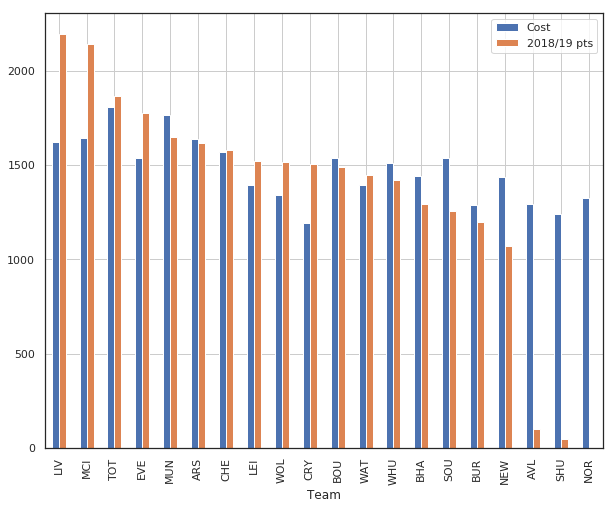

In [159]:
df_teams.sort_values('2018/19 pts', ascending=False).plot.bar(y=['Cost', '2018/19 pts'], figsize=(10,8), grid=True)

In [160]:
df_teams.sort_values('Team Cost per Point 2018/19', ascending=False)['Team Cost per Point 2018/19']

Team
NOR          inf
SHU    24.780000
AVL    13.060606
NEW     1.340168
SOU     1.222753
BHA     1.115830
BUR     1.072440
MUN     1.070260
WHU     1.062544
BOU     1.030181
ARS     1.014842
CHE     0.994304
TOT     0.968934
WAT     0.963372
LEI     0.915900
WOL     0.881579
EVE     0.865730
CRY     0.794020
MCI     0.768549
LIV     0.738399
Name: Team Cost per Point 2018/19, dtype: float64

This means we should favour players from the bottom of this list to maximise the points per money. 3 LIV yplayers, then WOL, CRY, MCI and EVE

In [161]:
# 38 fixtures per season. Which team had most players playing > 60 minutes per game
df_mins = df[df['2018/19 mins'] > (60 * 38)]
df_mins.groupby('Team').count()['Player']

Team
ARS     8
BHA     8
BOU     6
BUR     7
CHE     7
CRY     8
EVE     8
LEI     7
LIV     8
MCI     8
MUN     9
NEW     4
SOU     2
TOT     6
WAT     8
WHU     5
WOL    10
Name: Player, dtype: int64

This means teams like SOU have a high rotation risk. Should focus on WOL, LIV, MCI, LEI, WAT, CRY, EVE, BUR

# Use Integer Linear Programming to pick an optimal team based on last year's performance

In [162]:
# ILP team, inspiration from 
# https://github.com/kangeugine/fantasy-football/blob/master/%5BPart%202%5D%20Knapsack%20Problem.ipynb
from pulp import *

In [163]:
# only consider players who have data from last season
# what to do about all the new players in SHU and NOR?

def build_lp_vars(dfo):  
    lp_vars = {}
    
    lp_vars['player'] = [str(i) for i in dfo.index.tolist()]
    lp_vars['point'] = {str(i): int(dfo.loc[i]['2018/19 pts']) for i in dfo.index.tolist() }
    lp_vars['cost'] = {str(i): int(dfo.loc[i]['Cost']) for i in dfo.index.tolist()} 
    lp_vars['gk'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '1' else 0 for i in dfo.index.tolist()} 
    lp_vars['defe'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '2' else 0 for i in dfo.index.tolist()}
    lp_vars['mid'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '3' else 0 for i in dfo.index.tolist()}
    lp_vars['stri'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '4' else 0 for i in dfo.index.tolist()}

    # constrain on max 3 per team ... there may be a prettier way to do this .. 
    lp_vars['ars'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'ARS' else 0 for i in dfo.index.tolist()}
    lp_vars['bha'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BHA' else 0 for i in dfo.index.tolist()}
    lp_vars['bou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BOU' else 0 for i in dfo.index.tolist()}
    lp_vars['bur'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BUR' else 0 for i in dfo.index.tolist()}
    lp_vars['che'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CHE' else 0 for i in dfo.index.tolist()}
    lp_vars['cry'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CRY' else 0 for i in dfo.index.tolist()}
    lp_vars['eve'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'EVE' else 0 for i in dfo.index.tolist()}
    lp_vars['lei'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LEI' else 0 for i in dfo.index.tolist()}
    lp_vars['liv'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LIV' else 0 for i in dfo.index.tolist()}
    lp_vars['mci'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MCI' else 0 for i in dfo.index.tolist()}
    lp_vars['mun'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MUN' else 0 for i in dfo.index.tolist()}
    lp_vars['new'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NEW' else 0 for i in dfo.index.tolist()}
    lp_vars['sou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SOU' else 0 for i in dfo.index.tolist()}
    lp_vars['tot'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'TOT' else 0 for i in dfo.index.tolist()}
    lp_vars['wat'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WAT' else 0 for i in dfo.index.tolist()}
    lp_vars['whu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WHU' else 0 for i in dfo.index.tolist()}
    lp_vars['wol'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WOL' else 0 for i in dfo.index.tolist()}
    lp_vars['nor'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NOR' else 0 for i in dfo.index.tolist()}
    lp_vars['shu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SHU' else 0 for i in dfo.index.tolist()}
    lp_vars['avl'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'AVL' else 0 for i in dfo.index.tolist()}
    lp_vars['xi'] = {str(i): 1 for i in dfo.index.tolist()}
    
    return lp_vars
    
df_optimise = df[pd.notnull(df['2018/19 pts'])]
LP_VAR = build_lp_vars(df_optimise)

In [164]:
TEAMS = ['ars', 'bha', 'bou', 'bur', 'che', 'cry', 'eve', 'lei', 'liv', 'mci', 'mun',
         'new', 'sou', 'tot', 'wat', 'whu', 'wol', 'nor', 'shu', 'avl']

def build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tot_cost = 830, tot_players = 11, 
                tgt = LP_VAR['point'], lp_vars = LP_VAR):

    # objective function, maximise total points
    prob = LpProblem("Fantasy Football",LpMaximize)
    player = lp_vars['player']
    
    player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)
    prob += lpSum([tgt[i]*player_vars[i] for i in player]), "Total Points"

    # Team configuration (adjust for 4-4-2, 4-3-3, etc.)
    prob += lpSum([player_vars[i] for i in player]) == tot_players, tot_players
    prob += lpSum([lp_vars['cost'][i] * player_vars[i] for i in player]) == tot_cost, "Total Cost Max Playing"
    prob += lpSum([lp_vars['gk'][i] * player_vars[i] for i in player]) == n_gk, "1 GK"
    prob += lpSum([lp_vars['defe'][i] * player_vars[i] for i in player]) == n_defe, "4 DEF"
    prob += lpSum([lp_vars['mid'][i] * player_vars[i] for i in player]) == n_mid, "4 MID"
    prob += lpSum([lp_vars['stri'][i] * player_vars[i] for i in player]) == n_fwd, "2 STR"

    
    for t in TEAMS:
        prob += lpSum([lp_vars[t][i] * player_vars[i] for i in player]) <= 3, t

    
    return prob

In [165]:
# solve
prob = build_lp_team()
status = prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [166]:
# Extract which players were picked by the solver and mark in our dataframe
def extract_xi(dfo, prob = prob):  

    # can't write to slice
    dfo = dfo.copy()
    
    selection = {}
    for v in prob.variables():
        index = int(v.name.split("_")[1])
        selection[index] = v.varValue

    dfo['integer_programming'] = 0.0
    for i in selection:
        dfo.loc[i, 'integer_programming'] = selection[i]
    
    return dfo[dfo['integer_programming'] == 1.0]

In [167]:
# stats from the selected 11
def print_summary_xi(df_optimise, prob, points = '2018/19 pts', cost = 'Cost'):
    xi = extract_xi(df_optimise, prob)
    t_points = xi[points].sum()
    t_cost = xi[cost].sum()/10
    t_players = xi.shape[0]
    print("Total points:{}, cost:£{}, and with players:{}\n".format(t_points, t_cost, t_players))
    
    return xi

In [168]:
# permute team formations

# 442
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("442 formation")
xi442 = print_summary_xi(df_optimise, prob)
display(xi442[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))


# 433
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 3, n_fwd = 3)
status = prob.solve()

print("\n")
print("Status:", LpStatus[prob.status])
print("432 formation")
xi433 = print_summary_xi(df_optimise, prob)
display(xi433[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))


# 451
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 5, n_fwd = 1)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("451 formation")
xi451 = print_summary_xi(df_optimise, prob)
display(xi451[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))

# 352
prob = build_lp_team(n_gk = 1, n_defe = 3, n_mid = 5, n_fwd = 2)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("352 formation")
xi352 = print_summary_xi(df_optimise, prob)
display(xi352[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))



Status: Optimal
442 formation
Total points:2091.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Pickford,1,EVE,161.0,54,7.2
1,David Luiz,2,ARS,164.0,58,5.1
2,Robertson,2,LIV,213.0,71,22.0
3,van Dijk,2,LIV,208.0,64,40.2
4,Laporte,2,MCI,177.0,63,2.0
5,Fraser,3,BOU,181.0,69,3.0
6,Sigurdsson,3,EVE,182.0,74,2.8
7,Salah,3,LIV,259.0,122,21.6
8,Sterling,3,MCI,234.0,118,24.9
9,Wood,4,BUR,131.0,62,1.1




Status: Optimal
432 formation
Total points:2087.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Pickford,1,EVE,161.0,54,7.2
1,David Luiz,2,ARS,164.0,58,5.1
2,Robertson,2,LIV,213.0,71,22.0
3,van Dijk,2,LIV,208.0,64,40.2
4,Laporte,2,MCI,177.0,63,2.0
5,Fraser,3,BOU,181.0,69,3.0
6,Salah,3,LIV,259.0,122,21.6
7,Sterling,3,MCI,234.0,118,24.9
8,Callum Wilson,4,BOU,168.0,75,5.7
9,King,4,BOU,141.0,61,4.2




Status: Optimal
451 formation
Total points:2108.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Fabianski,1,WHU,143.0,49,2.1
1,David Luiz,2,ARS,164.0,58,5.1
2,Robertson,2,LIV,213.0,71,22.0
3,van Dijk,2,LIV,208.0,64,40.2
4,Laporte,2,MCI,177.0,63,2.0
5,Fraser,3,BOU,181.0,69,3.0
6,Milivojevic,3,CRY,166.0,67,2.5
7,Sigurdsson,3,EVE,182.0,74,2.8
8,Salah,3,LIV,259.0,122,21.6
9,Sterling,3,MCI,234.0,118,24.9




Status: Optimal
352 formation
Total points:2069.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Ederson,1,MCI,169.0,60,14.6
1,Robertson,2,LIV,213.0,71,22.0
2,van Dijk,2,LIV,208.0,64,40.2
3,Laporte,2,MCI,177.0,63,2.0
4,Fraser,3,BOU,181.0,69,3.0
5,Milivojevic,3,CRY,166.0,67,2.5
6,Sigurdsson,3,EVE,182.0,74,2.8
7,Salah,3,LIV,259.0,122,21.6
8,Sterling,3,MCI,234.0,118,24.9
9,King,4,BOU,141.0,61,4.2


# ILP, pick a bench for 17M



In [169]:
# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 1, n_mid = 1, n_fwd = 1, tot_players = 4, tot_cost = 170)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1111 bench")
iv1111 = print_summary_xi(df_optimise, prob)
display(iv1111[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))

# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 2, n_mid = 0, n_fwd = 1, tot_players = 4, tot_cost = 170)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1201 bench")
iv1201 = print_summary_xi(df_optimise, prob)
display(iv1201[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))



Status: Optimal
1111 bench
Total points:243.0, cost:£17.0, and with players:4



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Lössl,1,EVE,99.0,43,0.3
1,Morgan,2,LEI,76.0,41,0.7
2,Mendy,3,LEI,58.0,43,1.0
3,Nketiah,4,ARS,10.0,43,0.6




Status: Optimal
1201 bench
Total points:280.0, cost:£17.0, and with players:4



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Lössl,1,EVE,99.0,43,0.3
1,Morgan,2,LEI,76.0,41,0.7
2,Lascelles,2,NEW,95.0,43,3.1
3,Nketiah,4,ARS,10.0,43,0.6


# 2019 Current Season

In [203]:
gw = 17
last = gw - 1

# reload players from local storage
df = pd.read_excel(r'Players_2019_2020.xlsx', sheet_name='Sheet1')
df.set_index('PlayerId', inplace=True)

base_cols = ['Position', 'Cost', 'Status', 'Team', 'Selected', '2018/19 pts']
pts_cols = [str(i) + ' pts' for i in range(1,gw)]
mins_cols = [str(i) + ' mins' for i in range(1,gw)]

# next 5 fixture difficulties
fds5_cols = [str(i) + ' fds' for i in range(0,5)]
ppg5_cols = [str(i) + ' pts' for i in range(gw-6,gw)]

val_col = str(last) + 'val'

In [204]:
df.columns.values

array(['Player', 'Position', 'Cost', 'Status', 'Team', 'Selected',
       '2006/07 mins', '2006/07 pts', '2007/08 mins', '2007/08 pts',
       '2008/09 mins', '2008/09 pts', '2009/10 mins', '2009/10 pts',
       '2010/11 mins', '2010/11 pts', '2011/12 mins', '2011/12 pts',
       '2012/13 mins', '2012/13 pts', '2013/14 mins', '2013/14 pts',
       '2014/15 mins', '2014/15 pts', '2015/16 mins', '2015/16 pts',
       '2016/17 mins', '2016/17 pts', '2017/18 mins', '2017/18 pts',
       '2018/19 mins', '2018/19 pts', '1 bonus', '1 home', '1 mins',
       '1 pts', '1 val', '10 bonus', '10 home', '10 mins', '10 pts',
       '10 val', '11 bonus', '11 home', '11 mins', '11 pts', '11 val',
       '12 bonus', '12 home', '12 mins', '12 pts', '12 val', '13 bonus',
       '13 home', '13 mins', '13 pts', '13 val', '14 bonus', '14 home',
       '14 mins', '14 pts', '14 val', '15 bonus', '15 home', '15 mins',
       '15 pts', '15 val', '16 bonus', '16 home', '16 mins', '16 pts',
       '16 val', '2 bo

In [205]:
# compute total points 2019, total minutes 2019, 

df['COST'] = df['Cost']/10
df['PTS'] = df[pts_cols].sum(axis=1)
df['MINS'] = df[mins_cols].sum(axis=1)
df['FDS5'] = df[fds5_cols].sum(axis=1)
df['PPG5'] = df[ppg5_cols].sum(axis=1)/5

df['FDS5'].describe()

count    569.000000
mean      15.151142
std        1.881621
min       11.000000
25%       13.000000
50%       15.000000
75%       16.000000
max       18.000000
Name: FDS5, dtype: float64

In [207]:
# compute points/game 2019/20, minutes/game 2019/20, points/million 2019/20
df['PPG'] = df['PTS']/last
df['MPG'] = df['MINS']/last
df['PPM'] = df['PTS']/df['COST']

# this is a fiddle to fix
df['ADJPPG5'] = df['PPG']/df['FDS5']*df['FDS5'].mean()

summary_cols = ['Player', 'Position', 'COST', 'Status', 'Team', 'Selected', 'PTS', 'MINS', 'PPG', 'PPG5', 'MPG', 'PPM', 'FDS5', 'ADJPPG5' ]
df[summary_cols].sort_values('ADJPPG5', ascending=False).head(10)

,Player,Position,COST,Status,Team,Selected,PTS,MINS,PPG,PPG5,MPG,PPM,FDS5,ADJPPG5
PlayerId,,,,,,,,,,,,,,
166,Vardy,4,10.1,a,LEI,50.6,128.0,1440.0,8.0000,10.8,90.0000,12.673267,16,7.575571
233,Rashford,4,8.9,a,MUN,23.5,101.0,1396.0,6.3125,9.0,87.2500,11.348315,13,7.357045
192,Mané,3,12.3,a,LIV,42.7,109.0,1236.0,6.8125,9.0,77.2500,8.861789,16,6.451072
342,Son,3,10.0,a,TOT,19.9,88.0,1143.0,5.5000,9.4,71.4375,8.800000,13,6.410099
460,Abraham,4,7.9,a,CHE,36.1,97.0,1131.0,6.0625,7.2,70.6875,12.278481,15,6.123587
338,Kane,4,10.9,a,TOT,19.1,83.0,1344.0,5.1875,5.6,84.0000,7.614679,13,6.045889
215,De Bruyne,3,10.2,a,MCI,38.7,97.0,1222.0,6.0625,5.0,76.3750,9.509804,16,5.740863
11,Aubameyang,4,10.8,a,ARS,20.2,101.0,1440.0,6.3125,8.4,90.0000,9.351852,18,5.313421
313,Ings,4,6.3,a,SOU,11.5,84.0,1074.0,5.2500,8.2,67.1250,13.333333,15,5.302900


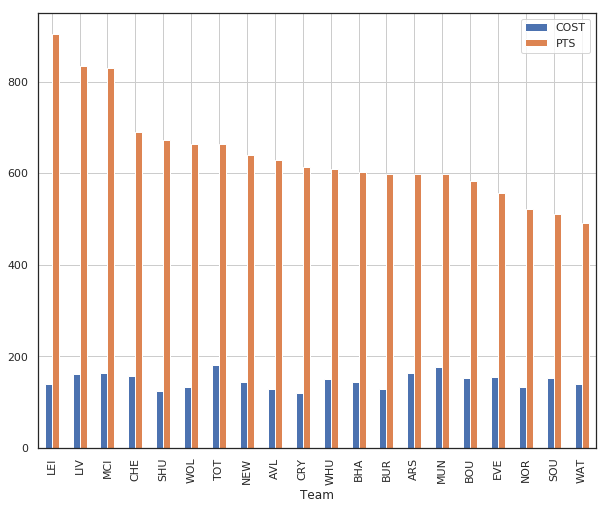

In [208]:
df_teams = df.groupby(['Team']).sum()
df_teams['Team Cost per Point 2019/20'] = df_teams['COST']/df_teams['PTS']
df_teams.sort_values('PTS', ascending=False).plot.bar(y=['COST', 'PTS'], figsize=(10,8), grid=True)

In [209]:
df_teams.sort_values('Team Cost per Point 2019/20', ascending=False)['Team Cost per Point 2019/20']

Team
SOU    0.300783
MUN    0.295485
WAT    0.283910
EVE    0.276661
ARS    0.273957
TOT    0.272440
BOU    0.263014
NOR    0.253155
WHU    0.247869
BHA    0.239635
CHE    0.227352
NEW    0.224688
BUR    0.215025
AVL    0.205238
WOL    0.201504
MCI    0.198434
CRY    0.194625
LIV    0.194371
SHU    0.184101
LEI    0.154033
Name: Team Cost per Point 2019/20, dtype: float64

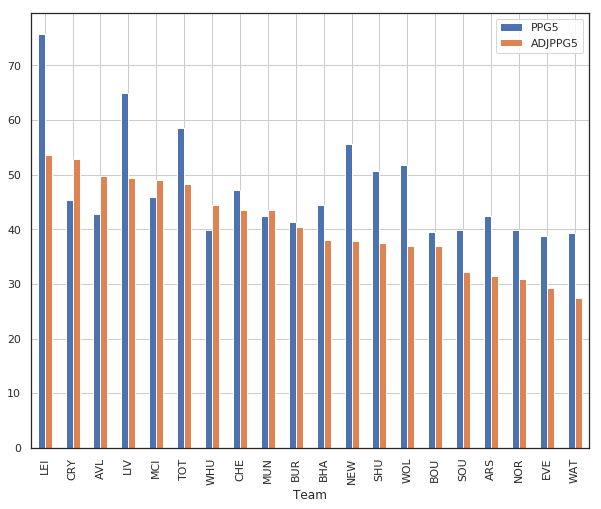

In [210]:
df_teams.sort_values('ADJPPG5', ascending=False).plot.bar(y=['PPG5', 'ADJPPG5'], figsize=(10,8), grid=True)

In [211]:
df[['PPG5','ADJPPG5']].describe()

,PPG5,ADJPPG5
count,569.000000,569.000000
mean,1.663620,1.430394
std,1.993006,1.493409
min,-0.200000,0.000000
25%,0.000000,0.067639
50%,1.000000,1.019788
75%,2.800000,2.330945
max,10.800000,7.575571


In [212]:
# only consider players who have data from last season

def build_lp_vars_curr(dfo):  
    lp_vars = {}
    
    lp_vars['player'] = [str(i) for i in dfo.index.tolist()]
    lp_vars['point'] = {str(i): int(dfo.loc[i]['PTS']) for i in dfo.index.tolist() }
    lp_vars['cost'] = {str(i): int(dfo.loc[i]['Cost']) for i in dfo.index.tolist()} 
    lp_vars['mins'] = {str(i): int(dfo.loc[i]['MINS']) for i in dfo.index.tolist() }
    lp_vars['ppg'] = {str(i): int(dfo.loc[i]['PPG']) for i in dfo.index.tolist() }
    lp_vars['fds5'] = {str(i): int(dfo.loc[i]['FDS5']) for i in dfo.index.tolist() }
    lp_vars['adjppg5'] = {str(i): int(dfo.loc[i]['ADJPPG5']) for i in dfo.index.tolist() }
    lp_vars['ppg5'] = {str(i): int(dfo.loc[i]['PPG5']) for i in dfo.index.tolist() }

    lp_vars['gk'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '1' else 0 for i in dfo.index.tolist()} 
    lp_vars['defe'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '2' else 0 for i in dfo.index.tolist()}
    lp_vars['mid'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '3' else 0 for i in dfo.index.tolist()}
    lp_vars['stri'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '4' else 0 for i in dfo.index.tolist()}

    # constrain on max 3 per team ... there may be a prettier way to do this .. 
    lp_vars['ars'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'ARS' else 0 for i in dfo.index.tolist()}
    lp_vars['bha'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BHA' else 0 for i in dfo.index.tolist()}
    lp_vars['bou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BOU' else 0 for i in dfo.index.tolist()}
    lp_vars['bur'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BUR' else 0 for i in dfo.index.tolist()}
    lp_vars['che'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CHE' else 0 for i in dfo.index.tolist()}
    lp_vars['cry'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CRY' else 0 for i in dfo.index.tolist()}
    lp_vars['eve'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'EVE' else 0 for i in dfo.index.tolist()}
    lp_vars['lei'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LEI' else 0 for i in dfo.index.tolist()}
    lp_vars['liv'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LIV' else 0 for i in dfo.index.tolist()}
    lp_vars['mci'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MCI' else 0 for i in dfo.index.tolist()}
    lp_vars['mun'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MUN' else 0 for i in dfo.index.tolist()}
    lp_vars['new'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NEW' else 0 for i in dfo.index.tolist()}
    lp_vars['sou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SOU' else 0 for i in dfo.index.tolist()}
    lp_vars['tot'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'TOT' else 0 for i in dfo.index.tolist()}
    lp_vars['wat'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WAT' else 0 for i in dfo.index.tolist()}
    lp_vars['whu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WHU' else 0 for i in dfo.index.tolist()}
    lp_vars['wol'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WOL' else 0 for i in dfo.index.tolist()}
    lp_vars['nor'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NOR' else 0 for i in dfo.index.tolist()}
    lp_vars['shu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SHU' else 0 for i in dfo.index.tolist()}
    lp_vars['avl'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'AVL' else 0 for i in dfo.index.tolist()}
    lp_vars['xi'] = {str(i): 1 for i in dfo.index.tolist()}
    
    return lp_vars
    
# Players must have points score and be available for selection
df_optimise_curr = df[pd.notnull(df['PTS'])]
df_optimise_curr = df_optimise_curr[df_optimise_curr['Status'] == 'a']

LP_VAR_CURR = build_lp_vars_curr(df_optimise_curr)

In [213]:
# def build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tot_cost = 830, tot_players = 11, 
#               tgt = LP_VAR['point'], lp_vars = LP_VAR):

# permute team formations

cols = ['Player','Position', 'Team','PTS','COST', 'PPM', 'MPG', 'PPG', 'Selected', 'FDS5']
t = LP_VAR_CURR['adjppg5']
v = LP_VAR_CURR
tc = 840

# 442
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tgt = t, tot_cost = tc, lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("442 formation")
xi442 = print_summary_xi(df_optimise_curr, prob, points = 'PTS')
display(xi442[cols].sort_values(['Position']).reset_index(drop=True))


# 433
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 3, n_fwd = 3, tgt = t, tot_cost = tc, lp_vars = v)
status = prob.solve()

print("\n")
print("Status:", LpStatus[prob.status])
print("433 formation")
xi433 = print_summary_xi(df_optimise_curr, prob, points='PTS')
display(xi433[cols].sort_values(['Position']).reset_index(drop=True))


# 451
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 5, n_fwd = 1, tgt = t, tot_cost = tc, lp_vars = v)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("451 formation")
xi451 = print_summary_xi(df_optimise_curr, prob, points='PTS')
display(xi451[cols].sort_values(['Position']).reset_index(drop=True))

# 352
prob = build_lp_team(n_gk = 1, n_defe = 3, n_mid = 5, n_fwd = 2, tgt = t, tot_cost = tc, lp_vars = v)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("352 formation")
xi352 = print_summary_xi(df_optimise_curr, prob, points = 'PTS')
display(xi352[cols].sort_values(['Position']).reset_index(drop=True))



Status: Optimal
442 formation
Total points:900.0, cost:£84.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.7500,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.0000,3.1250,28.7,11
2,Pereira,2,LEI,83.0,6.5,12.769231,90.0000,5.1875,17.4,16
3,Alexander-Arnold,2,LIV,68.0,7.3,9.315068,87.0000,4.2500,30.8,16
4,Lundstram,2,SHU,78.0,5.1,15.294118,88.0000,4.8750,47.1,17
5,Grealish,3,AVL,66.0,6.1,10.819672,78.3125,4.1250,7.2,12
6,Mané,3,LIV,109.0,12.3,8.861789,77.2500,6.8125,42.7,16
7,Mahrez,3,MCI,68.0,8.3,8.192771,41.1250,4.2500,3.5,16
8,Son,3,TOT,88.0,10.0,8.800000,71.4375,5.5000,19.9,13
9,Vardy,4,LEI,128.0,10.1,12.673267,90.0000,8.0000,50.6,16




Status: Optimal
433 formation
Total points:941.0, cost:£84.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.7500,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.0000,3.1250,28.7,11
2,Evans,2,LEI,75.0,5.2,14.423077,88.1875,4.6875,4.7,16
3,Alexander-Arnold,2,LIV,68.0,7.3,9.315068,87.0000,4.2500,30.8,16
4,Lundstram,2,SHU,78.0,5.1,15.294118,88.0000,4.8750,47.1,17
5,Maddison,3,LEI,86.0,7.8,11.025641,82.6250,5.3750,27.3,16
6,Mané,3,LIV,109.0,12.3,8.861789,77.2500,6.8125,42.7,16
7,Son,3,TOT,88.0,10.0,8.800000,71.4375,5.5000,19.9,13
8,Abraham,4,CHE,97.0,7.9,12.278481,70.6875,6.0625,36.1,15
9,Vardy,4,LEI,128.0,10.1,12.673267,90.0000,8.0000,50.6,16




Status: Optimal
451 formation
Total points:869.0, cost:£84.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.7500,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.0000,3.1250,28.7,11
2,Söyüncü,2,LEI,70.0,5.1,13.725490,90.0000,4.3750,20.4,16
3,Robertson,2,LIV,72.0,7.1,10.140845,89.0625,4.5000,22.0,16
4,Lundstram,2,SHU,78.0,5.1,15.294118,88.0000,4.8750,47.1,17
5,Grealish,3,AVL,66.0,6.1,10.819672,78.3125,4.1250,7.2,12
6,Maddison,3,LEI,86.0,7.8,11.025641,82.6250,5.3750,27.3,16
7,Salah,3,LIV,88.0,12.2,7.213115,68.7500,5.5000,21.6,16
8,Mané,3,LIV,109.0,12.3,8.861789,77.2500,6.8125,42.7,16
9,Son,3,TOT,88.0,10.0,8.800000,71.4375,5.5000,19.9,13




Status: Optimal
352 formation
Total points:930.0, cost:£84.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.7500,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.0000,3.1250,28.7,11
2,Söyüncü,2,LEI,70.0,5.1,13.725490,90.0000,4.3750,20.4,16
3,Lundstram,2,SHU,78.0,5.1,15.294118,88.0000,4.8750,47.1,17
4,Grealish,3,AVL,66.0,6.1,10.819672,78.3125,4.1250,7.2,12
5,Maddison,3,LEI,86.0,7.8,11.025641,82.6250,5.3750,27.3,16
6,Mané,3,LIV,109.0,12.3,8.861789,77.2500,6.8125,42.7,16
7,De Bruyne,3,MCI,97.0,10.2,9.509804,76.3750,6.0625,38.7,16
8,Son,3,TOT,88.0,10.0,8.800000,71.4375,5.5000,19.9,13
9,Abraham,4,CHE,97.0,7.9,12.278481,70.6875,6.0625,36.1,15


In [214]:
# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 1, n_mid = 1, n_fwd = 1, tot_players = 4, tot_cost = 196, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1111 bench")
iv1111 = print_summary_xi(df_optimise_curr, prob)
display(iv1111[cols].sort_values(['Position']).reset_index(drop=True))

# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 2, n_mid = 0, n_fwd = 1, tot_players = 4, tot_cost = 196, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1201 bench")
iv1201 = print_summary_xi(df_optimise_curr, prob)
display(iv1201[cols].sort_values(['Position']).reset_index(drop=True))

# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 1, n_mid = 2, n_fwd = 0, tot_players = 4, tot_cost = 196, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1120 bench")
iv1120 = print_summary_xi(df_optimise_curr, prob)
display(iv1120[cols].sort_values(['Position']).reset_index(drop=True))



Status: Optimal
1111 bench
Total points:192.0, cost:£19.6, and with players:4



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.750,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.000,3.1250,28.7,11
2,Shelvey,3,NEW,55.0,5.1,10.784314,53.125,3.4375,1.8,16
3,Ayew,4,CRY,54.0,5.1,10.588235,75.750,3.3750,7.3,11




Status: Optimal
1201 bench
Total points:162.0, cost:£19.6, and with players:4



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.75,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.00,3.1250,28.7,11
2,Söyüncü,2,LEI,70.0,5.1,13.725490,90.00,4.3750,20.4,16
3,Ayew,4,CRY,54.0,5.1,10.588235,75.75,3.3750,7.3,11




Status: Optimal
1120 bench
Total points:107.0, cost:£19.6, and with players:4



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Guaita,1,CRY,61.0,5.1,11.960784,78.7500,3.8125,2.1,11
1,Kelly,2,CRY,50.0,4.3,11.627907,54.0000,3.1250,28.7,11
2,El Ghazi,3,AVL,54.0,5.5,9.818182,58.8750,3.3750,1.1,12
3,Cantwell,3,NOR,60.0,4.7,12.765957,69.0625,3.7500,19.4,16


In [179]:
# Quick analysis of my team

picks = ['Henderson', 
         'Kelly', 'Söyüncü', 'Lundstram', 'Baldock',
         'De Bruyne', 'Mané', 'Maddison',
         'Rashford', 'Ings', 'Vardy']

df_pcks = df[df['Player'].isin(picks)]
df_pcks.head(11)

,Player,Position,Cost,Status,Team,Selected,2006/07 mins,2006/07 pts,2007/08 mins,2007/08 pts,...,9 fds,COST,PTS,MINS,FDS5,PPG5,PPG,MPG,PPM,ADJPPG5
PlayerId,,,,,,,,,,,,,,,,,,,,,
64,Kelly,2,44,d,BOU,0.1,NaN,NaN,NaN,NaN,...,3,4.4,0.0,0.0,17,0.0,0.0000,0.0000,0.000000,0.000000
128,Kelly,2,43,a,CRY,28.7,NaN,NaN,NaN,NaN,...,3,4.3,50.0,864.0,15,4.2,3.1250,54.0000,11.627907,3.750000
556,Henderson,1,40,a,CRY,0.2,NaN,NaN,NaN,NaN,...,3,4.0,0.0,0.0,15,0.0,0.0000,0.0000,0.000000,0.000000
164,Söyüncü,2,51,a,LEI,20.4,NaN,NaN,NaN,NaN,...,3,5.1,70.0,1440.0,18,8.6,4.3750,90.0000,13.725490,4.375000
166,Vardy,4,101,a,LEI,50.6,NaN,NaN,NaN,NaN,...,3,10.1,128.0,1440.0,18,14.8,8.0000,90.0000,12.673267,8.000000
171,Maddison,3,78,a,LEI,27.3,NaN,NaN,NaN,NaN,...,3,7.8,86.0,1322.0,18,10.0,5.3750,82.6250,11.025641,5.375000
192,Mané,3,123,a,LIV,42.7,NaN,NaN,NaN,NaN,...,2,12.3,109.0,1236.0,20,10.0,6.8125,77.2500,8.861789,6.131250
198,Henderson,3,54,a,LIV,1.0,NaN,NaN,NaN,NaN,...,2,5.4,46.0,995.0,20,6.0,2.8750,62.1875,8.518519,2.587500
215,De Bruyne,3,102,a,MCI,38.7,NaN,NaN,NaN,NaN,...,2,10.2,97.0,1222.0,18,6.2,6.0625,76.3750,9.509804,6.062500


In [180]:
df_pcks[['PTS','PPG', 'MINS', 'PPG5', 'ADJPPG5']].describe()

,PTS,PPG,MINS,PPG5,ADJPPG5
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,69.857143,4.366071,1084.785714,6.885714,4.363322
std,37.222527,2.326408,492.919119,4.071450,2.377941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,3.250000,1014.750000,4.650000,3.513158
50%,74.500000,4.656250,1279.000000,6.800000,4.496711
75%,94.250000,5.890625,1405.000000,9.650000,5.890625
max,128.000000,8.000000,1440.000000,14.800000,8.000000


In [181]:
df_pcks[['PPG', 'PPG5', 'ADJPPG5']].sum()

PPG        61.125000
PPG5       96.400000
ADJPPG5    61.086513
dtype: float64